## Week 4 Project

## 1.	Introduction:  
    - Let’s assume I would want to start a new business in Jersey City (or any other places), but I am not sure about what is the best business in this location that is most needed. For example, should I open a restaurant, or should I open a pharmacy, etc.?  
    - The goal is to find the best new businesses to open in Jersey City (or any other places).  
    - Clearly this would be an interesting topic to many investors and entrepreneurs


### Import Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## 2.	Data:  
    - Foursquare venue data for all neighborhoods in NY and Jersey City.  
    - Foursquare higher level venue catagory definition: for example, level I: Food, Level II: Asian Food, Level III: Chinese Food
    - The venue data is then reformated by one hot encoding, and averaging on neighborhood leve, such that each row in the data represents the distribution of the venue catagories in a neighborhood
    -- In this exercise, we will be focusing on the Level II venue catagories. Level III is way to granular and Level I does not carry enough information. So Level II is a good balance


### 2. 1 Load Map Data for New York and Jersey City

In [2]:
# with open('newyork_data.json') as json_data:
#     newyork_data = json.load(json_data)
# neighborhoods_data = newyork_data['features']
# # define the dataframe columns
# column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# # instantiate the dataframe
# neighborhoods = pd.DataFrame(columns=column_names)

In [3]:
# for data in neighborhoods_data:
#     borough = neighborhood_name = data['properties']['borough'] 
#     neighborhood_name = data['properties']['name']
        
#     neighborhood_latlon = data['geometry']['coordinates']
#     neighborhood_lat = neighborhood_latlon[1]
#     neighborhood_lon = neighborhood_latlon[0]
    
#     neighborhoods = neighborhoods.append({'Borough': borough,
#                                           'Neighborhood': neighborhood_name,
#                                           'Latitude': neighborhood_lat,
#                                           'Longitude': neighborhood_lon}, ignore_index=True)

In [4]:
# neighborhoods.to_csv('map_data_full.csv')

In [5]:
map_venues = pd.read_csv('map_data.csv')
map_venues.drop("Unnamed: 0",axis = 1,inplace = True)
print(map_venues.shape)

(313, 4)


In [6]:
map_venues["Neighborhood"] = map_venues["Borough"] + "_" + map_venues["Neighborhood"]

In [7]:
map_venues.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Manhattan_Marble Hill,40.876551,-73.910660
1,Manhattan,Manhattan_Chinatown,40.715618,-73.994279
2,Manhattan,Manhattan_Washington Heights,40.851903,-73.936900
3,Manhattan,Manhattan_Inwood,40.867684,-73.921210
4,Manhattan,Manhattan_Hamilton Heights,40.823604,-73.949688


In [8]:
address = 'New York City, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


####  Display the map to verify the input data

In [9]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(map_venues['Latitude'], map_venues['Longitude'], map_venues['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

### 2.2 Get Venue Data

#### Define Foursquare Credentials and Version

In [10]:
CLIENT_ID = 'GCYSXEPAHKWCKHMKMF4VD4U3P4ZYLSFK42YFUJI2SNB0PTTZ' # your Foursquare ID
CLIENT_SECRET = 'UEGFKNYSV0FWL0MBP3GBLHWTVAH0DYK2GI0YIJEG4I1JEQDO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GCYSXEPAHKWCKHMKMF4VD4U3P4ZYLSFK42YFUJI2SNB0PTTZ
CLIENT_SECRET:UEGFKNYSV0FWL0MBP3GBLHWTVAH0DYK2GI0YIJEG4I1JEQDO


#### Foursqure API calls

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results_temp = requests.get(url).json()["response"]
            results = results_temp['groups'][0]['items']
        except:
            #import traceback
            #traceback.print_exc()
            #input("Program crashed; press Enter to exit")
            print("Error Occured at ", name)
            #return(results_temp)
        
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue Name', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
#nearby_venues = getNearbyVenues(names=map_venues['Neighborhood'],
#                                  latitudes=map_venues['Latitude'],
#                                  longitudes=map_venues['Longitude']
#                                 )
#nearby_venues.to_csv('venue_data_full2.csv')

#### The codes above will save the venue data into a csv file, so we can now load directly

In [13]:
nearby_venues = pd.read_csv('venue_data_full2.csv')
nearby_venues.drop("Unnamed: 0",axis = 1,inplace = True)
print(nearby_venues.shape)

(10392, 7)


In [14]:
nearby_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Manhattan_Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Manhattan_Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Manhattan_Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Manhattan_Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Manhattan_Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


### 2.3 Fetch the difinition of Foursqure Higher Level Catagories

Foursquare default venue category is too granular, let's take a look at higher levels

In [15]:
url =  "https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}".format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)

results_c = requests.get(url).json()

Append higher level venue data to the original venue data file

In [16]:
venues_list = []
for results in results_c["response"]['categories']:
    for results2 in results['categories']:
        if results2['categories'] != []:
            for results3 in results2['categories']:
                if results3['categories'] != []:
                    for results4 in results3['categories']:
                        venues_list.append([results['name'],results2['name'],results3['name'],results4['name']])
                else:
                    venues_list.append([results['name'],results2['name'],results3['name'],results3['name']])    
        else:
                venues_list.append([results['name'],results2['name'],results2['name'],results2['name']])

Delete the redundant columns

In [17]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

catagory_list = pd.DataFrame([venue_list for venue_list in venues_list])
catagory_list.columns = ['Level I', 'Level II','Level III','Level IV']
# catagory_list.rename(columns={"A": "Level I", "B": "Level II","B": "Level III","B": "Level IV"})

print(nearby_venues.shape)
nearby_venues_full = pd.merge(nearby_venues,catagory_list,left_on='Venue Category', right_on='Level IV',how = "left");
print(nearby_venues_full.shape)

catagory_list2 = catagory_list[:]
catagory_list2.drop(['Level IV'],axis = 1,inplace=True)
catagory_list2.columns = ['Level I 2', 'Level II 2','Level III 2']
nearby_venues_full = pd.merge(nearby_venues_full,catagory_list2,left_on='Venue Category', right_on='Level III 2',how = "left");
nearby_venues_full = nearby_venues_full.drop_duplicates();
print(nearby_venues_full.shape)

catagory_list2 = catagory_list[:]
catagory_list2.drop(['Level III','Level IV'],axis = 1,inplace=True)
catagory_list2.columns = ['Level I 3', 'Level II 3']
nearby_venues_full = pd.merge(nearby_venues_full,catagory_list2,left_on='Venue Category', right_on='Level II 3',how = "left");
nearby_venues_full = nearby_venues_full.drop_duplicates();
print(nearby_venues_full.shape)

catagory_list2 = catagory_list[:]
catagory_list2.drop(['Level II','Level III','Level IV'],axis = 1,inplace=True)
catagory_list2.columns = ['Level I 4']
nearby_venues_full = pd.merge(nearby_venues_full,catagory_list2,left_on='Venue Category', right_on='Level I 4',how = "left");
nearby_venues_full = nearby_venues_full.drop_duplicates();
print(nearby_venues_full.shape)

(10392, 7)
(10392, 11)
(10392, 14)
(10392, 16)
(10392, 17)


In [18]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

nearby_venues_full["Level I"][nearby_venues_full["Level I"].isnull()] = nearby_venues_full["Level I 2"][nearby_venues_full["Level I"].isnull()] 
nearby_venues_full["Level I"][nearby_venues_full["Level I"].isnull()] = nearby_venues_full["Level I 3"][nearby_venues_full["Level I"].isnull()] 
nearby_venues_full["Level I"][nearby_venues_full["Level I"].isnull()] = nearby_venues_full["Level I 4"][nearby_venues_full["Level I"].isnull()] 

nearby_venues_full["Level II"][nearby_venues_full["Level II"].isnull()] = nearby_venues_full["Level II 2"][nearby_venues_full["Level II"].isnull()] 
nearby_venues_full["Level II"][nearby_venues_full["Level II"].isnull()] = nearby_venues_full["Level II 3"][nearby_venues_full["Level II"].isnull()] 

nearby_venues_full["Level III"][nearby_venues_full["Level III"].isnull()] = nearby_venues_full["Level III 2"][nearby_venues_full["Level III"].isnull()] 

nearby_venues_full["Level II"][nearby_venues_full["Level II"].isnull()] = nearby_venues_full["Level I"][nearby_venues_full["Level II"].isnull()]
nearby_venues_full["Level III"][nearby_venues_full["Level III"].isnull()] = nearby_venues_full["Level II"][nearby_venues_full["Level III"].isnull()]
nearby_venues_full["Level IV"][nearby_venues_full["Level IV"].isnull()] = nearby_venues_full["Level III"][nearby_venues_full["Level IV"].isnull()]

nearby_venues_full.drop(['Level I 2','Level II 2','Level III 2','Level I 3','Level II 3','Level I 4'],axis = 1,inplace = True)

In [19]:
nearby_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Manhattan_Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Manhattan_Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Manhattan_Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Manhattan_Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Manhattan_Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


In [20]:
nearby_venues_full.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category,Level I,Level II,Level III,Level IV
0,Manhattan_Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place,Food,Pizza Place,Pizza Place,Pizza Place
1,Manhattan_Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio,Outdoors & Recreation,Athletics & Sports,Gym / Fitness Center,Yoga Studio
2,Manhattan_Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner,Food,Diner,Diner,Diner
3,Manhattan_Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop,Food,Coffee Shop,Coffee Shop,Coffee Shop
4,Manhattan_Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop,Food,Donut Shop,Donut Shop,Donut Shop


### 2.4 Data Reformating

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


In [22]:
def dataReformat(df, column):
    num_top_venues = 5
    # one hot encoding
    data_onehot = pd.get_dummies(df[column], prefix="", prefix_sep="")
    # add neighborhood column back to dataframe
    data_onehot['Neighborhood'] = df['Neighborhood'] 
    # move neighborhood column to the first column
    fixed_columns = [data_onehot.columns[-1]] + list(data_onehot.columns[:-1])
    data_onehot = data_onehot[fixed_columns]
    
    data_grouped = data_onehot.groupby('Neighborhood').mean().reset_index()
    data_grouped.head()
    
    indicators = ['st', 'nd', 'rd']
    # create columns according to number of top venues
    columns = ['Neighborhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
    neighborhoods_venues_sorted['Neighborhood'] = data_grouped['Neighborhood']

    for ind in np.arange(data_grouped.shape[0]):
        neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(data_grouped.iloc[ind, :], num_top_venues)
    
    return [data_onehot,data_grouped,neighborhoods_venues_sorted]
    

In [23]:
[data_onehot,data_grouped,neighborhoods_venues_sorted] = dataReformat(nearby_venues_full,'Level II')

In [24]:
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head(10)

(311, 6)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bronx_Allerton,Pizza Place,Deli / Bodega,Food & Drink Shop,Department Store,Asian Restaurant
1,Bronx_Baychester,Donut Shop,Bank,Convenience Store,Sandwich Place,Electronics Store
2,Bronx_Bedford Park,Diner,Mexican Restaurant,Pizza Place,Deli / Bodega,Sandwich Place
3,Bronx_Belmont,Italian Restaurant,Food & Drink Shop,Pizza Place,Deli / Bodega,Bakery
4,Bronx_Bronxdale,Food & Drink Shop,Italian Restaurant,Paper / Office Supplies Store,Bank,Mexican Restaurant
5,Bronx_Castle Hill,Southern / Soul Food Restaurant,Bus Station,Market,Pharmacy,Bank
6,Bronx_City Island,Spanish Restaurant,Seafood Restaurant,Thrift / Vintage Store,Jewelry Store,Food & Drink Shop
7,Bronx_Claremont Village,Food & Drink Shop,Asian Restaurant,Bus Station,Bakery,Pizza Place
8,Bronx_Clason Point,Park,Pool,Food & Drink Shop,Boat or Ferry,Latin American Restaurant
9,Bronx_Co-op City,Bus Station,Food & Drink Shop,Discount Store,Salon / Barbershop,Bagel Shop


In [25]:
print(data_grouped.shape)
data_grouped.head()

(311, 287)


,Neighborhood,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Bath House,Beach,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Child Care Service,Chocolate Shop,Circus,Clothing Store,Club House,Coffee Shop,College Academic Building,College Bookstore,College Cafeteria,College Stadium,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Czech Restaurant,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Entertainment Service,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Fast Food Restaurant,Field,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Government Building,Greek Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Heliport,Herbs & Spices Store,Historic Site,Hobby Shop,Home Service,Hot Dog Joint,Hotel,IT Services,Indian Restaurant,Intersection,Irish Pub,Italian Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Library,Locksmith,Lounge,Market,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Office,Optical Shop,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Outlet Mall,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Pier,Piercing Parlor,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Post Office,Print Shop,Professional & Other Places,Public Art,Racetrack,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Rest Area,Restaurant,River,Road,Rock Climbing Spot,Roller Rink,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shop & Service,Shopping Mall,Shopping Plaza,Ski Area,Smoke Shop,Smoothie Shop,Snack Place,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sri Lankan Restaurant,Stables,Stadium,State / Provincial Park,States & Municipalities,Steakhouse,Storage Facility,Strip Club,Supplement Shop,Swiss Restaurant,Tailor Shop,Tanning Salon,Tattoo Parlor,Tea Room,Theme Park,Theme Restaurant,Thrift / Vintage Store,Toll Plaza,Tourist Information Center,Toy / Game Store,Trail,Train St

## 3.	Methodology:
    - In the last step, we've already aggregated the venue data in each neighborhood, so that we would know the distributions of venues within each neighborhood. This data will be used as input data.
    - Run K Means algorithm to divide the neighborhoods into different groups. We will also test the algorithm performance with different K.
     - I've also tested other clustering algorithms, but given the high dimension, K means is the most robust choice (i.e. the outcome won't change too much with different number of clusters)
    - Pick out the group that Jersey City belongs to, and calculate the intra-cluster similarity
    - In order to find the best venue, we will iteratively add a new venue to each of the venue category in Jersey City one by one, while keeping all other venue numbers unchanged, and then update the intra-cluster similarity. 
    - The most needed business is defined to be the venue that will give us the most increment of the intra-cluster similarity. 
    - The above steps are repeated with different Ks so we can better understand the robustness of the model  
    - Finally, we will combine the output of K means with different Ks into one single scores for each venue catagory, and that will be our final proposal


### 3.1 Cluster Test: K Means

### Find the best K in K means

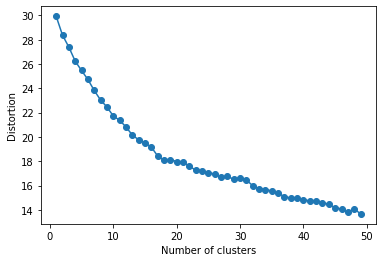

In [103]:
import matplotlib.pyplot as plt
data_grouped_clustering = data_grouped.drop('Neighborhood', 1)
distortions = []
for i in range(1, 50):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=3000,
        tol=1e-05, random_state=0
    )
    km.fit(data_grouped_clustering+0.01)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 50), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

### No clear elbow point can be found, therefore just as an example, let's first take 20 as an example

In [65]:
# K Means
# set number of clusters
kclusters = 20
data_grouped_clustering = data_grouped.drop('Neighborhood', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(data_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([ 2, 11,  2,  2,  2, 11, 11,  0, 11, 11])

In [66]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted['Cluster Labels'] = kmeans.labels_
data_merged = map_venues

# merge to add latitude/longitude for each neighborhood
data_merged = pd.merge(data_merged,neighborhoods_venues_sorted, on='Neighborhood',how = 'right')
print(neighborhoods_venues_sorted.shape)
print(data_merged.shape)

(311, 7)
(311, 10)


#### Visualize the clusters on Map

In [67]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(data_merged['Latitude'], data_merged['Longitude'], data_merged['Neighborhood'], data_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Take Jersey City 07310 as an example

In [78]:
g = neighborhoods_venues_sorted["Cluster Labels"].values[neighborhoods_venues_sorted["Neighborhood"] == "Bronx_Allerton"][0]
print(neighborhoods_venues_sorted[neighborhoods_venues_sorted["Cluster Labels"] == g].shape)
mydf = data_grouped[neighborhoods_venues_sorted["Cluster Labels"] == g]
#mydf.to_csv('mydata.csv')
mydf[["Neighborhood","Bank"]].head()

(61, 7)


,Neighborhood,Bank
0,Bronx_Allerton,0.000000
2,Bronx_Bedford Park,0.000000
3,Bronx_Belmont,0.031579
4,Bronx_Bronxdale,0.071429
13,Bronx_East Tremont,0.052632


In [107]:
g = data_merged["Cluster Labels"].values[data_merged["Neighborhood"] == "Bronx_Allerton"][0]
print(data_merged[data_merged["Cluster Labels"] == g].shape)
mydf = data_merged[data_merged["Cluster Labels"] == g]
#mydf.to_csv('mydata.csv')
mydf

(61, 10)


,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels
43,Jersey City,Jersey City_JC07307,40.748001,-74.049430,Pizza Place,Spanish Restaurant,Sandwich Place,Asian Restaurant,Donut Shop,2
51,Bronx,Bronx_Kingsbridge,40.881687,-73.902818,Pizza Place,Bar,Food & Drink Shop,Latin American Restaurant,Mexican Restaurant,2
53,Bronx,Bronx_Norwood,40.877224,-73.879391,Pizza Place,Bank,Park,Food & Drink Shop,American Restaurant,2
56,Bronx,Bronx_Pelham Parkway,40.857413,-73.854756,Dessert Shop,Italian Restaurant,Pizza Place,Deli / Bodega,Asian Restaurant,2
58,Bronx,Bronx_Bedford Park,40.870185,-73.885512,Diner,Mexican Restaurant,Pizza Place,Deli / Bodega,Sandwich Place,2
60,Bronx,Bronx_Morris Heights,40.847898,-73.919672,Spanish Restaurant,Pizza Place,Bus Station,Bank,Food & Drink Shop,2
62,Bronx,Bronx_East Tremont,40.842696,-73.887356,Pizza Place,Cosmetics Shop,Clothing Store,Café,Bank,2
64,Bronx,Bronx_High Bridge,40.836623,-73.926102,Pharmacy,Asian Restaurant,Latin American Restaurant,Seafood Restaurant,Food & Drink Shop,2
65,Bronx,Bronx_Melrose,40.819754,-73.909422,Pizza Place,Pharmacy,Food & Drink Shop,Athletics & Sports,Sandwich Place,2
78,Bronx,Bronx_Morris Park,40.847549,-73.850402,Pizza Place,Deli / Bodega,Bakery,Burger Joint,Donut Shop,2


In [80]:
a1 = mydf['1st Most Common Venue'].value_counts().rename_axis('Venue').reset_index(name='Most Popular') 
a2 = mydf['2nd Most Common Venue'].value_counts().rename_axis('Venue').reset_index(name='2nd Popular') 
a3 = mydf['3rd Most Common Venue'].value_counts().rename_axis('Venue').reset_index(name='3rd Popular') 
a4 = pd.merge(pd.merge(a1,a2,on = "Venue",how = "outer"),a3,on = 'Venue',how = "outer")
a4 = a4.fillna(0);
a4

,Venue,Most Popular,2nd Popular,3rd Popular
0,Pizza Place,15.0,13.0,7.0
1,Food & Drink Shop,11.0,7.0,8.0
2,Asian Restaurant,11.0,8.0,7.0
3,Italian Restaurant,5.0,4.0,2.0
4,Deli / Bodega,5.0,3.0,1.0
5,Bus Station,2.0,2.0,1.0
6,Bank,2.0,2.0,2.0
7,Lounge,1.0,0.0,0.0
8,Bagel Shop,1.0,0.0,0.0
9,Rental Car Location,1.0,0.0,0.0


### 3.2 Find the best new business in Neighborhood: JC 07310 when k = 20

Now let's try to find the best new business in JC 07310 -- the idea is, we will add a new venue in each of the venue catagories one by one, then we will take a look at the change in intra-cluster similiarity. The best business would be the one that results in the largest increment in the intra-cluster similarity 

Take a look at the most sensitive venue in each JC 07310

In [91]:
pd.options.mode.chained_assignment = None  # default='warn'
from scipy.spatial import distance_matrix

Neighborhood = 'Bronx_Allerton'
groupNumber = neighborhoods_venues_sorted["Cluster Labels"].values[neighborhoods_venues_sorted["Neighborhood"] == Neighborhood][0]
ind_Neighborhood = np.where(neighborhoods_venues_sorted['Neighborhood'][neighborhoods_venues_sorted["Cluster Labels"] == groupNumber] == Neighborhood)[0][0]
c = len(nearby_venues.loc[nearby_venues['Neighborhood'] == Neighborhood,'Neighborhood'])
data_grouped_clustering_temp = data_grouped_clustering[:]
data_with_in_group = data_grouped_clustering_temp[neighborhoods_venues_sorted["Cluster Labels"] == groupNumber]
dist_matrix = distance_matrix(data_with_in_group,data_with_in_group) 
totalDistance_original = sum(dist_matrix[ind_Neighborhood,:])
totalDistance = []
totalDistanceDF = []
for i in range(0,data_grouped_clustering.shape[1]):
    
    data_grouped_clustering_temp = data_grouped_clustering[:]
    data_with_in_group = data_grouped_clustering_temp[neighborhoods_venues_sorted["Cluster Labels"] == groupNumber]
    data_with_in_group.iloc[ind_Neighborhood,i] = data_with_in_group.iloc[ind_Neighborhood,i] +1/c
    data_with_in_group.iloc[ind_Neighborhood,:] = data_with_in_group.iloc[ind_Neighborhood,:]/sum(data_with_in_group.iloc[ind_Neighborhood,:])
    dist_matrix = distance_matrix(data_with_in_group,data_with_in_group) 
    totalDistance.append(sum(dist_matrix[ind_Neighborhood,:]))
    #print("New Distance: {:.4f}".format(sum(dist_matrix[ind_Neighborhood,:])))
    totalDistanceDF.append([data_with_in_group.columns[i],sum(dist_matrix[ind_Neighborhood,:]),sum(dist_matrix[ind_Neighborhood,:]) - totalDistance_original])
    
totalDistance_sorted = sorted(totalDistance)
print("Neighborhood:",Neighborhood)
print("Original Distance: {:.3f}".format(totalDistance_original))
print("The best business is     : --{}--     with distance reduced to {:.3f}".format(data_grouped_clustering_temp.columns[totalDistance.index(totalDistance_sorted[0])],totalDistance_sorted[0]))
print("The 2nd best business is : --{}--     with distance reduced to {:.3f}".format(data_grouped_clustering_temp.columns[totalDistance.index(totalDistance_sorted[1])],totalDistance_sorted[1]))
print("The 3rd best business is : --{}--     with distance reduced to {:.3f}".format(data_grouped_clustering_temp.columns[totalDistance.index(totalDistance_sorted[2])],totalDistance_sorted[2]))

Neighborhood: Bronx_Allerton
Original Distance: 15.922
The best business is     : --Bank--     with distance reduced to 15.549
The 2nd best business is : --Italian Restaurant--     with distance reduced to 15.576
The 3rd best business is : --Bakery--     with distance reduced to 15.632


In [102]:
totalDistanceDF = pd.DataFrame(totalDistanceDF,columns= ['Venue','Distance','Delta in Distance'])
totalDistanceDF = totalDistanceDF.sort_values(by=['Delta in Distance'], ascending=True).reset_index()
totalDistanceDF

,index,Venue,Distance,Delta in Distance
0,21,Bank,15.549499,-0.372283
1,141,Italian Restaurant,15.576119,-0.345663
2,20,Bakery,15.632218,-0.289564
3,230,Sandwich Place,15.635771,-0.286011
4,163,Mexican Restaurant,15.666826,-0.254956
5,19,Bagel Shop,15.676339,-0.245443
6,22,Bar,15.681945,-0.239837
7,78,Diner,15.712208,-0.209574
8,59,Coffee Shop,15.719045,-0.202737
9,46,Café,15.727091,-0.194691


### 3.3 Iterate the above process with different Ks
Now let's convert all above steps into a function, and loop through different Ks to check the best businesses.   
Such step can increase the robustness of our algorithm, given there is no clear elbow point in K means

In [33]:
def FindBestVenues(kclusters, neighborhoods_venues_sorted, map_venues,outputDF,Neighborhood):
    data_grouped_clustering = data_grouped.drop('Neighborhood', 1)
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(data_grouped_clustering)

    # add clustering labels
    neighborhoods_venues_sorted['Cluster Labels'] = kmeans.labels_
    data_merged = map_venues[:]
    data_merged = pd.merge(data_merged,neighborhoods_venues_sorted, on='Neighborhood',how = 'right')

    #Neighborhood = 'Jersey City_JC07310'
    groupNumber = neighborhoods_venues_sorted["Cluster Labels"].values[neighborhoods_venues_sorted["Neighborhood"] == Neighborhood][0]
    ind_Neighborhood = np.where(neighborhoods_venues_sorted['Neighborhood'][neighborhoods_venues_sorted["Cluster Labels"] == groupNumber] == Neighborhood)[0][0]
    c = len(nearby_venues.loc[nearby_venues['Neighborhood'] == Neighborhood,'Neighborhood'])
    data_grouped_clustering_temp = data_grouped_clustering[:]
    data_with_in_group = data_grouped_clustering_temp[neighborhoods_venues_sorted["Cluster Labels"] == groupNumber]
    dist_matrix = distance_matrix(data_with_in_group,data_with_in_group) 
    totalDistance_original = sum(dist_matrix[ind_Neighborhood,:])
    totalDistance = []
    for i in range(0,data_grouped_clustering.shape[1]):

        data_grouped_clustering_temp = data_grouped_clustering[:]
        data_with_in_group = data_grouped_clustering_temp[neighborhoods_venues_sorted["Cluster Labels"] == groupNumber]
        data_with_in_group.iloc[ind_Neighborhood,i] = data_with_in_group.iloc[ind_Neighborhood,i] +1/c
        data_with_in_group.iloc[ind_Neighborhood,:] = data_with_in_group.iloc[ind_Neighborhood,:]/sum(data_with_in_group.iloc[ind_Neighborhood,:])
        dist_matrix = distance_matrix(data_with_in_group,data_with_in_group) 
        totalDistance.append(sum(dist_matrix[ind_Neighborhood,:]))
        #print("New Distance: {:.4f}".format(sum(dist_matrix[ind_Neighborhood,:])))


    totalDistance_sorted = sorted(totalDistance)
    print("Neighborhood:",Neighborhood)
    print("K = ",kclusters)
    print("Number of Neighborhood in the Group: ",data_with_in_group.shape[0])
    print("Original Distance: {:.3f}".format(totalDistance_original))
    print("The best business is     : -- {} --     with distance reduced to {:.3f}".format(data_grouped_clustering_temp.columns[totalDistance.index(totalDistance_sorted[0])],totalDistance_sorted[0]))
    print("The 2nd best business is : -- {} --     with distance reduced to {:.3f}".format(data_grouped_clustering_temp.columns[totalDistance.index(totalDistance_sorted[1])],totalDistance_sorted[1]))
    print("The 3rd best business is : -- {} --     with distance reduced to {:.3f}".format(data_grouped_clustering_temp.columns[totalDistance.index(totalDistance_sorted[2])],totalDistance_sorted[2]))

    outputDF.append([kclusters,data_with_in_group.shape[0],data_grouped_clustering_temp.columns[totalDistance.index(totalDistance_sorted[0])],data_grouped_clustering_temp.columns[totalDistance.index(totalDistance_sorted[1])],data_grouped_clustering_temp.columns[totalDistance.index(totalDistance_sorted[2])]])
    return outputDF

Loop through different K's in K Means

In [34]:
outputDF = []
pd.options.mode.chained_assignment = None  # default='warn'
for k in range(5,41):
    #FindBestVenues(k, neighborhoods_venues_sorted, map_venues,outputDF,'Jersey City_JC07310')
    FindBestVenues(k, neighborhoods_venues_sorted, map_venues,outputDF,"Bronx_Allerton")

Neighborhood: Bronx_Allerton
K =  5
Number of Neighborhood in the Group:  135
Original Distance: 42.443
The best business is     : -- Bank --     with distance reduced to 41.727
The 2nd best business is : -- Sandwich Place --     with distance reduced to 41.746
The 3rd best business is : -- Bar --     with distance reduced to 41.838
Neighborhood: Bronx_Allerton
K =  6
Number of Neighborhood in the Group:  69
Original Distance: 20.182
The best business is     : -- Food & Drink Shop --     with distance reduced to 19.764
The 2nd best business is : -- Caribbean Restaurant --     with distance reduced to 19.890
The 3rd best business is : -- Bakery --     with distance reduced to 19.898
Neighborhood: Bronx_Allerton
K =  7
Number of Neighborhood in the Group:  157
Original Distance: 45.971
The best business is     : -- Bank --     with distance reduced to 45.110
The 2nd best business is : -- Sandwich Place --     with distance reduced to 45.201
The 3rd best business is : -- Bakery --     wit

Neighborhood: Bronx_Allerton
K =  30
Number of Neighborhood in the Group:  22
Original Distance: 5.941
The best business is     : -- Bank --     with distance reduced to 5.809
The 2nd best business is : -- Pizza Place --     with distance reduced to 5.827
The 3rd best business is : -- Bagel Shop --     with distance reduced to 5.838
Neighborhood: Bronx_Allerton
K =  31
Number of Neighborhood in the Group:  19
Original Distance: 5.061
The best business is     : -- Bar --     with distance reduced to 4.962
The 2nd best business is : -- Bakery --     with distance reduced to 4.981
The 3rd best business is : -- Pizza Place --     with distance reduced to 4.990
Neighborhood: Bronx_Allerton
K =  32
Number of Neighborhood in the Group:  58
Original Distance: 15.294
The best business is     : -- Bank --     with distance reduced to 14.956
The 2nd best business is : -- Latin American Restaurant --     with distance reduced to 15.029
The 3rd best business is : -- Sandwich Place --     with dista

### 3.4 Summarize the outcomes for different Ks into one single table

#### Now let's take a look at the top 3 most needed venue with different K

In [104]:
outputDF_Final = pd.DataFrame (outputDF,columns=['K','Neiborhoods in the Group','Best Business','2nd Best Business','3rd Best Business'])
outputDF_Final

,K,Neiborhoods in the Group,Best Business,2nd Best Business,3rd Best Business
0,5,135,Bank,Sandwich Place,Bar
1,6,69,Food & Drink Shop,Caribbean Restaurant,Bakery
2,7,157,Bank,Sandwich Place,Bakery
3,8,101,Bank,Sandwich Place,Beach
4,9,72,Food & Drink Shop,Caribbean Restaurant,Bakery
5,10,72,Bank,Bus Stop,Sandwich Place
6,11,116,Bank,Sandwich Place,Bakery
7,12,45,Bank,Bar,Sandwich Place
8,13,67,Bank,Sandwich Place,Italian Restaurant
9,14,46,Bank,Bar,Sandwich Place


#### Let's aggregate the results of all Ks, and summarize into one single table.

In addition, we will also define scores for each venue in the table. For each K, we assign 3 points to the best venue, 2 points to the 2nd best, and 1 points to the 3rd, then we aggregate onto venue level

In [36]:
def findBest(outputDF_Final):
    B1 = outputDF_Final["Best Business"].value_counts().rename_axis('Venue').reset_index(name='Best') 
    B2 = outputDF_Final["2nd Best Business"].value_counts().rename_axis('Venue').reset_index(name='2nd') 
    B3 = outputDF_Final["3rd Best Business"].value_counts().rename_axis('Venue').reset_index(name='3rd') 
    Summary = pd.merge(pd.merge(B1,B2,on = "Venue",how = "outer"),B3,on = 'Venue',how = "outer")
    Summary = Summary.fillna(0);
    Summary["Final Score"] = Summary["Best"]*3 + Summary["2nd"]*2 + Summary["3rd"]*1
    Summary = Summary.sort_values(by=['Final Score'], ascending=False).reset_index()
    Summary.drop(['index'],axis = 1,inplace = True)
    return(Summary)

## 4. Results:
    - Based on the output table, the two best venues that the code is recommending are Pharmacy and Sandwich Places
    - We have much less confidence in the other recommended venues in the table, as you can verify from their scores

In [37]:
Summary = findBest(outputDF_Final)
Summary

,Venue,Best,2nd,3rd,Final Score
0,Bank,25.0,1.0,2.0,79.0
1,Sandwich Place,0.0,10.0,8.0,28.0
2,Bar,3.0,5.0,6.0,25.0
3,Bakery,0.0,5.0,6.0,16.0
4,Pizza Place,1.0,2.0,3.0,10.0
5,Food & Drink Shop,3.0,0.0,0.0,9.0
6,Park,1.0,1.0,2.0,7.0
7,Mexican Restaurant,1.0,1.0,1.0,6.0
8,Caribbean Restaurant,0.0,3.0,0.0,6.0
9,Bagel Shop,1.0,0.0,2.0,5.0


## 5. Discussion:
    - Alought there is no clear elbow point that we can find, the outcome of different Ks in K means is actually quite consistent, which can be verified by the table above: the scores are highly concentraded in the top two venue: Pharmacy and Sandwich Places
    - There are other clustering algorithms that we can use for this exercise, such as DBScan, but their performance were questionable especially given the high dimension.
    

## 6. Conclusion :
    Based on the intra-group similarity analysis with K-means clustering algorithm, we found the best new venue in Jersey City to be Pharmacy and Sandwich Places
    